In [1]:
import os
import numpy as np
import pandas as pd
import ipywidgets as widgets
from glmtools.io.glm import GLMDataset
from datetime import datetime, timedelta

In [2]:
from glmtools.test.common import get_sample_data_path

sample_path = get_sample_data_path()
samples = [
    "OR_GLM-L2-LCFA_G16_s20181830433000_e20181830433200_c20181830433231.nc",
    "OR_GLM-L2-LCFA_G16_s20181830433200_e20181830433400_c20181830433424.nc",
    "OR_GLM-L2-LCFA_G16_s20181830433400_e20181830434000_c20181830434029.nc",
]
samples = [os.path.join(sample_path, s) for s in samples]

## Create and plot grids of the sample data included in glmtools

The command below creates grids on the ABI fixed grid at 2 km. The `cmd` is an ordinary shell command - you can run it in a terminal or as part of a shell script.

The domain is a GOES mesoscale sector centered on the provided lon/lat. It is not necessary to provide the center if using the conus or full disk domains.

The start and end times will be inferred from the data files if not provided, and in this case would result in a grid with a single 1-min frame.

Here, we create a 5 min grid. This grid will be empty except for the minute (0433 UTC) corresponding to the data.

In [3]:
import subprocess
import os, glob
import tempfile
tmpdir = tempfile.TemporaryDirectory()

import glmtools
from glmtools.test.common import get_sample_data_path
glmtools_path = os.path.abspath(glmtools.__path__[0])

# Set the start time and duration
startdate = datetime(2018, 7, 2, 4, 30)
duration = timedelta(0, 60*5)
enddate = startdate+duration
    
cmd = "python /Users/ebruning/code/glmtools/examples/grid/make_GLM_grids.py"
cmd += " -o {1}/{{start_time:%Y/%b/%d}}/{{dataset_name}}"
cmd += " --fixed_grid --split_events --float_output"
cmd += " --goes_position=east --goes_sector=meso"
cmd += " --ctr_lat=33.5 --ctr_lon=-101.5 --dx=2.0 --dy=2.0"
cmd += " --start={3} --end={4} {2}"

cmd = cmd.format(glmtools_path, tmpdir.name, ' '.join(samples),
                startdate.isoformat(), enddate.isoformat())
# print (cmd)
out_bytes = subprocess.check_output(cmd.split())
# print(out_bytes.decode('utf-8'))

grid_dir_base = tmpdir.name
nc_files = glob.glob(os.path.join(grid_dir_base, startdate.strftime('%Y/%b/%d'),'*.nc'))
print(nc_files)

['/var/folders/sp/7k9p40wj1x9fdvwjbdrs4ffm0000gn/T/tmpe9l63pqu/2018/Jul/02/OR_GLM-L2-GLMM1-M3_G16_s20181830430000_e20181830431000_c20192151148320.nc', '/var/folders/sp/7k9p40wj1x9fdvwjbdrs4ffm0000gn/T/tmpe9l63pqu/2018/Jul/02/OR_GLM-L2-GLMM1-M3_G16_s20181830432000_e20181830433000_c20192151148320.nc', '/var/folders/sp/7k9p40wj1x9fdvwjbdrs4ffm0000gn/T/tmpe9l63pqu/2018/Jul/02/OR_GLM-L2-GLMM1-M3_G16_s20181830434000_e20181830435000_c20192151148320.nc', '/var/folders/sp/7k9p40wj1x9fdvwjbdrs4ffm0000gn/T/tmpe9l63pqu/2018/Jul/02/OR_GLM-L2-GLMM1-M3_G16_s20181830431000_e20181830432000_c20192151148320.nc', '/var/folders/sp/7k9p40wj1x9fdvwjbdrs4ffm0000gn/T/tmpe9l63pqu/2018/Jul/02/OR_GLM-L2-GLMM1-M3_G16_s20181830433000_e20181830434000_c20192151148320.nc']


**Run the cell below to see the log file created by the gridding process.**

In [4]:
%%bash
# cat make_GLM_grid.log

## Grab and load the files for each grid type

In [5]:
from glmtools.io.imagery import open_glm_time_series

glm_grids = open_glm_time_series(nc_files)

/Users/ebruning/anaconda/envs/glmval/lib/python3.6/site-packages/xarray/core/variable.py:133: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)


## Make an interactive plot with a map background

<IPython.core.display.Javascript object>


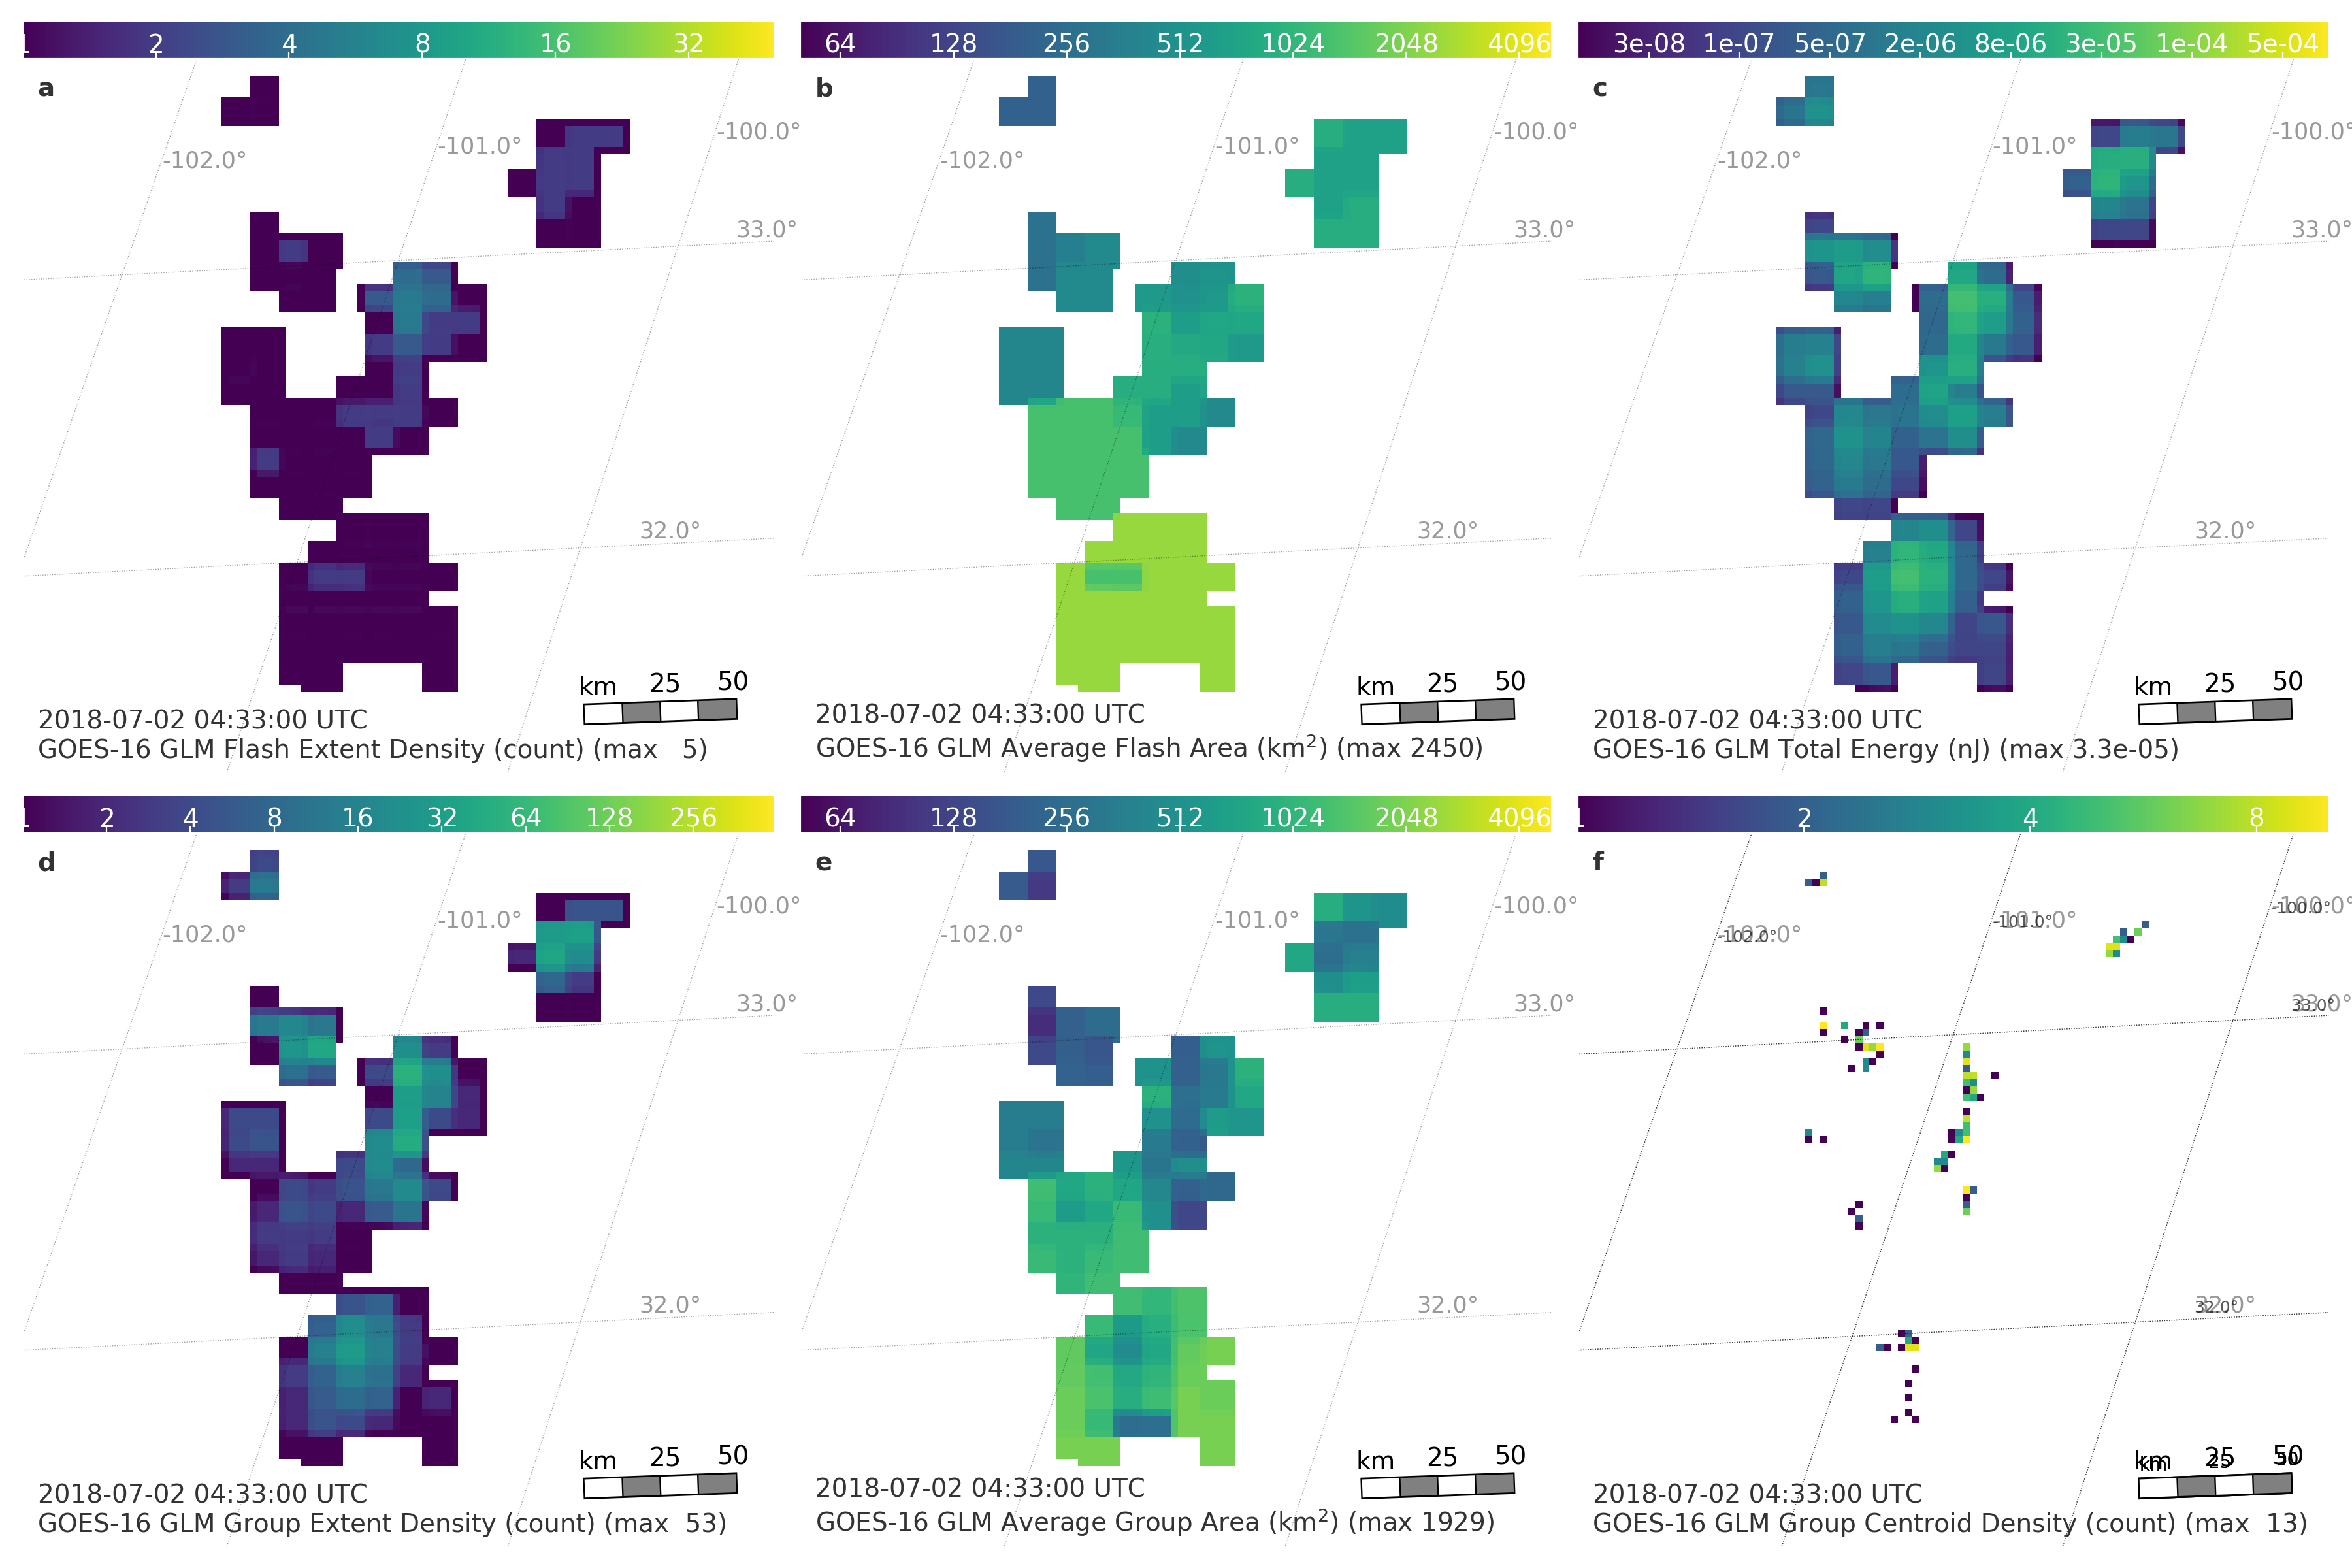

In [29]:
%matplotlib notebook
import matplotlib.pyplot as plt
from glmtools.plot.grid import plot_glm_grid

fields_6panel = ['flash_extent_density', 'average_flash_area','total_energy', 
                 'group_extent_density', 'average_group_area', 'group_centroid_density']



def plot(w, fig=None, time_widget=None, field_widget=None, subplots=(2,3), fields=None):
    t = pd.to_datetime(time_widget.value)
    n_subplots = subplots[0] * subplots[1]
    if fields is None:
        if n_subplots == 1:
            fields = [field_widget.value]
        else:
            fields = fields_6panel[0:n_subplots]

    mapax, cbar_obj = plot_glm_grid(fig, glm_grids, t, fields, subplots=subplots,
                                   axes_facecolor = (1.0, 1.0, 1.0), map_color = (0.2, 0.2, 0.2))


fig = plt.figure(figsize=(18,12))
plt.show()

In [30]:
from ipywidgets import widgets

time_options = [str(t0) for t0 in glm_grids.time.to_series()]
time_options.sort()
field_options = list(k for k in glm_grids.variables.keys() if 'nominal' not in k)
for v in ['x', 'y', 'time', 'goes_imager_projection', 'DQF']: field_options.remove(v)
field_dropdown = widgets.Dropdown(options=field_options)
time_slider = widgets.SelectionSlider(options=time_options)
glm_select = widgets.HBox([field_dropdown, time_slider])

from functools import partial
plot = partial(plot, fig=fig, field_widget=field_dropdown, time_widget=time_slider)
time_slider.observe(plot)
field_dropdown.observe(plot)

display(glm_select)
# plot('yo')
time_slider.value = time_slider.options[3]

In [31]:
# CONUS grid; zoom to domain that does't screw up colorbars
# fig.axes[0].axis((-2.43e6, -2.07e6, 3.15e6, 3.36e6))

# MESO grid
fig.axes[0].axis((-2.35e6, -2.14e6, 3.15e6, 3.36e6))

(-2350000.0, -2140000.0, 3150000.0, 3360000.0)

In [32]:
import cartopy.crs as ccrs
from glmtools.plot.mapscale import scale_bar

location = (0.87, .08)

pctrans = ccrs.PlateCarree()
for axid in range(6):# range(len(fig.axes)):
    ax = fig.axes[axid]
    llx0, llx1, lly0, lly1 = ax.get_extent(pctrans)
    lat_lines = np.arange(np.floor(lly0-.5), np.ceil(lly1+0.0), 1.0) #[31.5, 32, 32.5]
    lon_lines = np.arange(np.floor(llx0+1.0), np.ceil(llx1+0.5), 1.0) #[-102.0, -101.5, -101, -100.5, -100.0, -95.5]

    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    lldx = llx1-llx0
    lldy = lly1-lly0
    llctrx = (llx1 + llx0) / 2
    llctry = (lly1 + lly0) / 2
#     tmc = ccrs.AzimuthalEquidistant(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
#     x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
#     sbx = x0 + (x1 - x0) * location[0]
#     sby = y0 + (y1 - y0) * location[1]
    scale_bar(ax, location=location, fontsize=10, linewidth=10.0, text_pad=10)

    llcolor = (0.0, 0.0, 0.0, 0.4)

    for ilon in lon_lines:
        ax.plot([ilon, ilon], [lly0, lly1], transform=pctrans, color=llcolor, linewidth=0.5, linestyle=':')
        ax.text(ilon+.02, llctry+lldy*.3,'{0:3.1f}°'.format(ilon), transform=pctrans, color=llcolor, fontsize=9)

    for ilat in lat_lines:
        ax.plot([llx0, llx1], [ilat, ilat], transform=pctrans, color=llcolor, linewidth=0.5,linestyle=':')
        ax.text(llctrx+lldx*.3, ilat+.02,'{0:3.1f}°'.format(ilat), transform=pctrans, color=llcolor, fontsize=9)


    
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# lon_formatter = LongitudeFormatter(number_format='.1f',
#                                    degree_symbol='',
#                                    dateline_direction_label=True)
# lat_formatter = LatitudeFormatter(number_format='.1f',
#                                   degree_symbol='')
# ax.set_xticks([-101], crs=ccrs.PlateCarree())
# ax.set_yticks([32], crs=ccrs.PlateCarree())
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)

# ax.gridlines(draw_labels=True)

In [33]:
def set_fontsize(fig,fontsize):
    """
    For each text object of a figure fig, set the font size to fontsize
    """
    def match(artist):
        return artist.__module__ == "matplotlib.text"

    for textobj in fig.findobj(match=match):
        textobj.set_fontsize(textobj.get_fontsize()*1.4)
#         print(textobj.get_fontsize())

# Most start at 10 pt, and 14 pt basically fills the axes
set_fontsize(fig, 14)

In [34]:
fig.savefig('sixpanel_grids_rev1.pdf')

# Save an image of each frame

The code below loops through the slider positions and saves a figure at each step.
The cell below that displays one of those images.

In [10]:
# print(grid_dir_base)
# print(file_tag)
if False:
    images_out = []
    for option in time_slider.options[:]:
        time_slider.value = option
        resize_colorbar('foo')
        outfile=grid_dir_base + 'GLM_{1}_{0}.png'.format(option, file_tag)
        outfile = outfile.replace(' ', '_')
        outfile = outfile.replace(':', '')
        images_out.append(outfile)
        fig.savefig(outfile)
# print(images_out)

In [11]:
if False:
    from IPython.display import Image
    Image(images_out[3])

## Create a plot of the point data in the sample data files

In [36]:
# Get the limits of the gridded plot, and use for this plot
ax_lim_grid = fig.axes[0].axis()
print(ax_lim_grid)

(-2350000.0, -2140000.0, 3150000.0, 3360000.0)


<IPython.core.display.Javascript object>


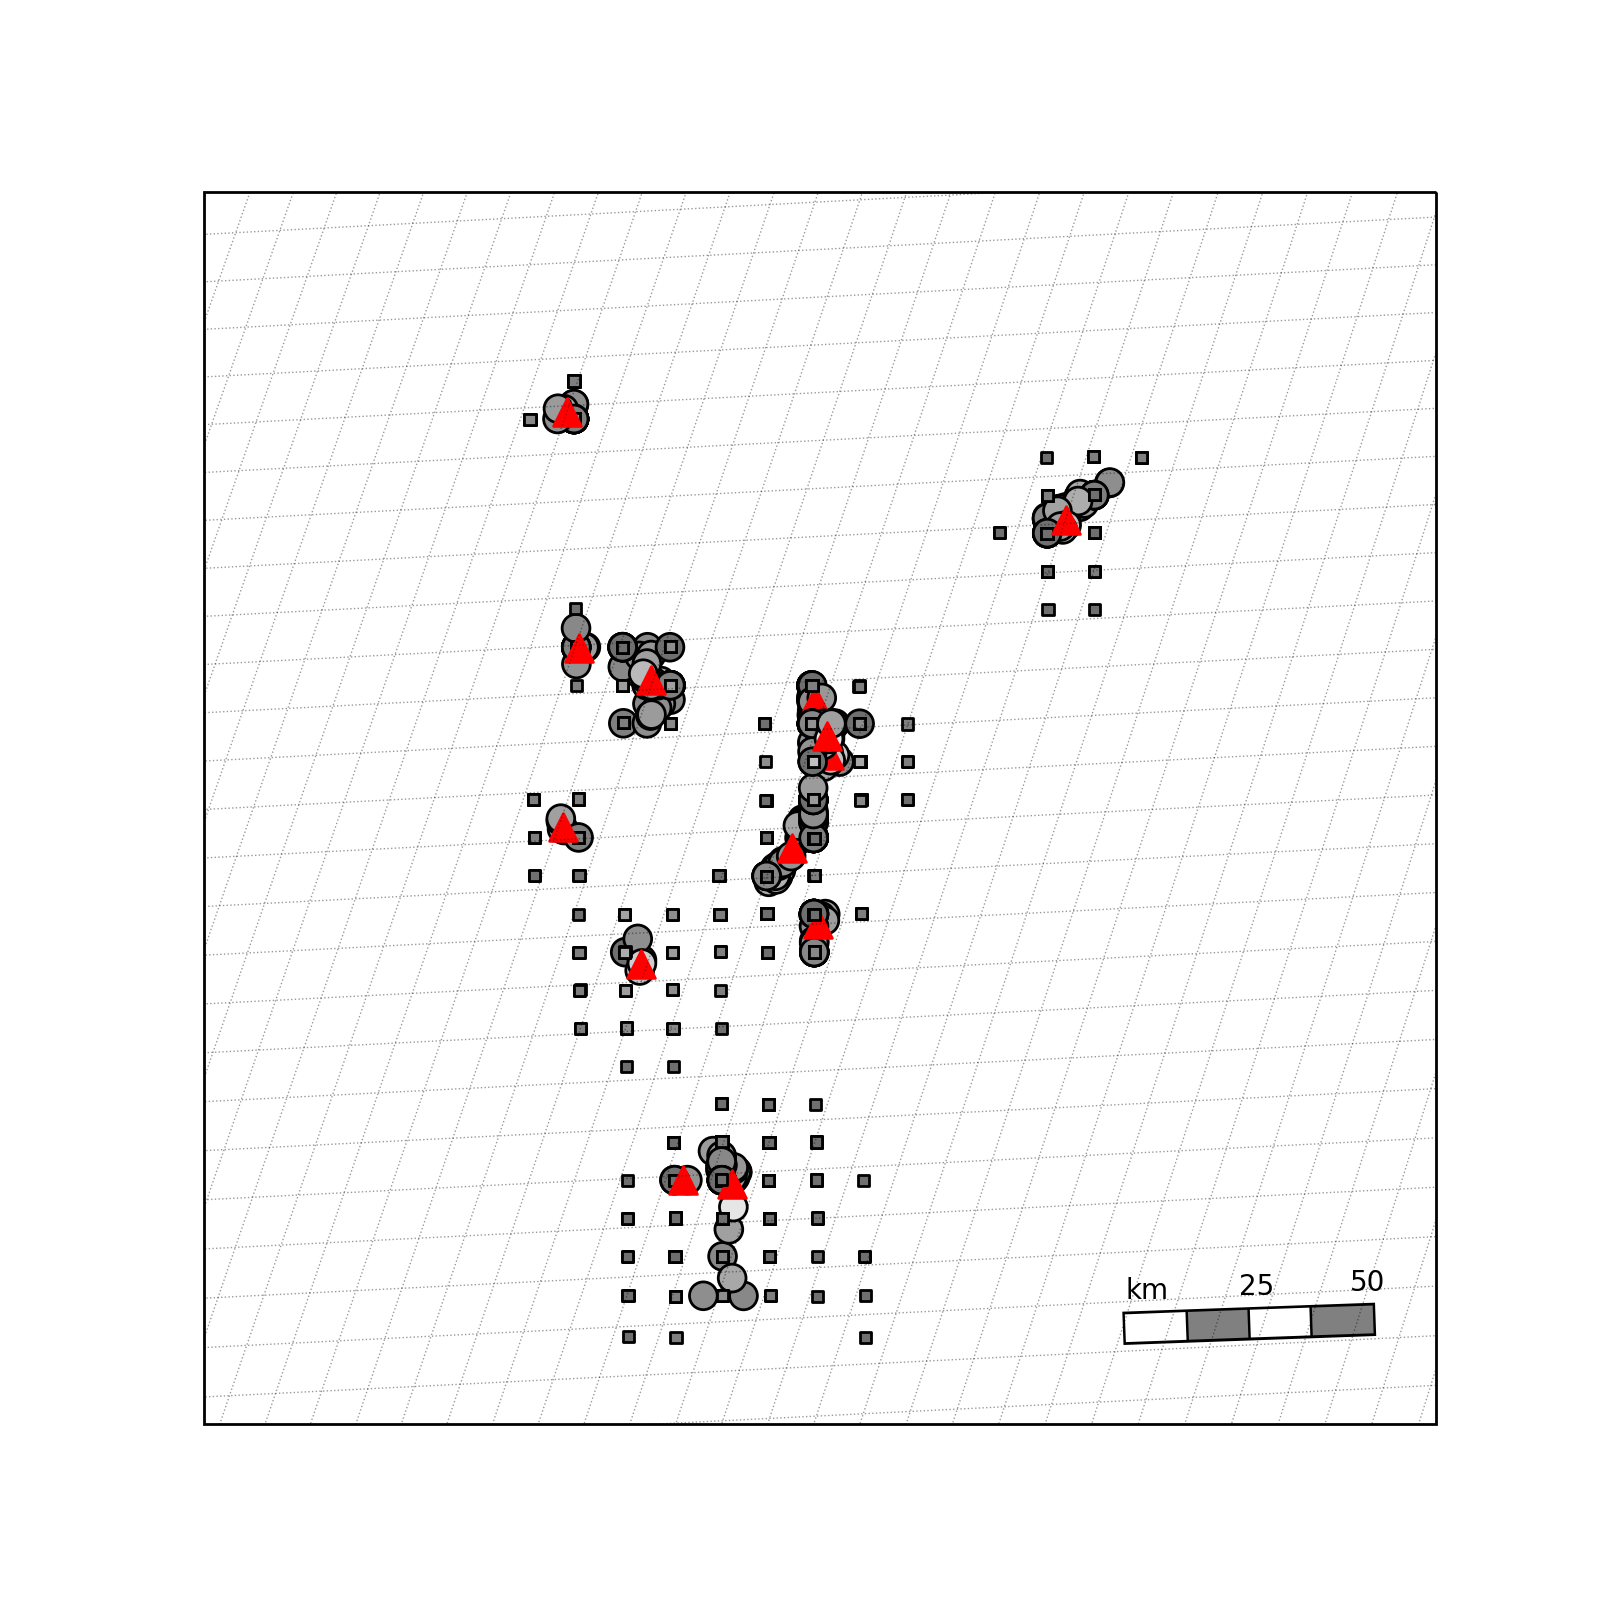

In [41]:
from glmtools.plot.locations import plot_flash
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader as ShapeReader

proj_var = glm_grids['goes_imager_projection']
fixed_lim = [v / proj_var.perspective_point_height for v in ax_lim_grid]

fig_pts = plt.figure(figsize=(8,8))
state_boundaries = cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lakes',
                                                scale='50m', facecolor='none')
globe = ccrs.Globe(semimajor_axis=proj_var.semi_major_axis, semiminor_axis=proj_var.semi_minor_axis)
proj = ccrs.Geostationary(central_longitude=proj_var.longitude_of_projection_origin,
                          satellite_height=proj_var.perspective_point_height, globe=globe)
ax = fig_pts.add_subplot(1, 1, 1, projection=proj)
ax.coastlines('10m', color='red')
ax.add_feature(state_boundaries, edgecolor='red')

for sample in samples:
    glm = GLMDataset(sample)
    flash_data = glm.subset_flashes(x_range = fixed_lim[0:2], y_range=fixed_lim[2:4])
    for flid in np.unique(flash_data.flash_id.data[:]):
        plot_flash(glm, flid, ax=ax, proj=ccrs.PlateCarree())
ax.axis(ax_lim_grid)
ax.set_title('')


import cartopy.crs as ccrs
from glmtools.plot.mapscale import scale_bar

location = (0.87, .08)

pctrans = ccrs.PlateCarree()
llx0, llx1, lly0, lly1 = ax.get_extent(pctrans)
lat_lines = np.arange(np.floor(lly0-.5), np.ceil(lly1+0.0), 0.1) #[31.5, 32, 32.5]
lon_lines = np.arange(np.floor(llx0-1.0), np.ceil(llx1+0.5), 0.1) #[-102.0, -101.5, -101, -100.5, -100.0, -95.5]

#Make tmc horizontally centred on the middle of the map,
#vertically at scale bar location
lldx = llx1-llx0
lldy = lly1-lly0
llctrx = (llx1 + llx0) / 2
llctry = (lly1 + lly0) / 2
#     tmc = ccrs.AzimuthalEquidistant(sbllx, sblly)
#Get the extent of the plotted area in coordinates in metres
#     x0, x1, y0, y1 = ax.get_extent(tmc)
#Turn the specified scalebar location into coordinates in metres
#     sbx = x0 + (x1 - x0) * location[0]
#     sby = y0 + (y1 - y0) * location[1]
scale_bar(ax, location=location, fontsize=10, linewidth=10.0, text_pad=10)

llcolor = (0.0, 0.0, 0.0, 0.4)

for ilon in lon_lines:
    ax.plot([ilon, ilon], [lly0, lly1], transform=pctrans, color=llcolor, linewidth=0.5, linestyle=':')
#     ax.text(ilon+.02, llctry+lldy*.3,'{0:3.1f}°'.format(ilon), transform=pctrans, color=llcolor, fontsize=9)

for ilat in lat_lines:
    ax.plot([llx0, llx1], [ilat, ilat], transform=pctrans, color=llcolor, linewidth=0.5,linestyle=':')
#     ax.text(llctrx+lldx*.3, ilat+.02,'{0:3.1f}°'.format(ilat), transform=pctrans, color=llcolor, fontsize=9)



In [42]:
fig_pts.savefig('sixpanel_points.pdf')

In [15]:
# Set the axes limit of the grid plot to match the zoom of the points
ax_lim_pts = ax.axis()
for axi in fig.axes[0:6]:
    axi.axis(ax_lim_pts)

In [40]:
ax.get_extent(ccrs.PlateCarree())

(-102.7064720770511, -99.06314184757134, 31.222324599162608, 33.88944125699078)